In [1]:
from math import inf
from math import log
import numpy as np
from scipy.stats import nbinom
from collections import defaultdict
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# log func

In [5]:
def log_func(number):
    if number > 0:
        return log(number)
    else:
        return -inf

# Simulate Data

In [6]:
random.seed(100)

mean_list_true = np.array([2, 300, 220, 180, 100, 60, 20, 200, 150, 100, 2, 500, 450, 400, 300, 200, 100, 450, 400, 350, 2]) # mean
#mean_list_true = np.array([5, 45,30,15, 40,20,10, 45,30,15, 5, 90,75,30, 60,50,20, 90,75,30, 5])


variance_list_true = mean_list_true*1.2 
beta_list_true = 1/(variance_list_true/mean_list_true-1)
alpha_list_true = mean_list_true * beta_list_true


trans_true = [0.5, 0.3, 0.8]
#state_dict = defaultdict(int)
def generate_nb(state):
    return np.random.negative_binomial(alpha_list_true[state-1], beta_list_true[state-1]/(1+beta_list_true[state-1]))

In [7]:
def simulate():
    
    state_1_2 = 0
    state_1_12 = 0
    state_11_12 = 0
    change_position = 0
    state_list = []
    
    # first five without AUG
    curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
    while 'AUG' in "".join(curr_RNA):
        curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
    curr_observed = [generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1), generate_nb(1)]
    state_list = [1, 1, 1, 1, 1]
    count = 5

    # check if AUG would occur
    start = random.choices([True, False], weights=np.ones(2), k = 1)[0]
    while start == False:
        
        # if no, generate single base
        curr_RNA += random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 1)[0]
        curr_observed.append(generate_nb(1))
        state_list.append(1)
        count += 1
        start = random.choices([True, False], weights=np.ones(2), k = 1)[0] # check if AUG occurs
        if "".join(curr_RNA[-3:]) == 'AUG':
            curr_RNA = curr_RNA[:-3]
            curr_observed = curr_observed[:-3]
            state_list = state_list[:-3]
            start = True
        if count >= 100:
            return (curr_RNA, curr_observed, [state_1_2, state_1_12, state_11_12], change_position, state_list)
        
            
    # choose to stay in state 1 or 2 or 12
    curr_RNA += ['A', 'U', 'G']
    state = random.choices([1, 2, 12], weights=[0.2, 0.5, 0.3], k = 1)[0]
   
    # if in state 1
    while state == 1:
        count += 3
        curr_observed += [generate_nb(1), generate_nb(1), generate_nb(1)] # NB for AUG
        state_list += [1, 1, 1]
        # check if AUG would occur
        start = random.choices([True, False], weights=np.ones(2), k = 1)[0]
        while start == False:      

            # if no, generate single base
            curr_RNA += random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 1)[0]
            curr_observed.append(generate_nb(1))
            state_list.append(1)
            count += 1
            start = random.choices([True, False], weights=np.ones(2), k = 1)[0] # check if AUG occurs
            if "".join(curr_RNA[-3:]) == 'AUG':
                curr_RNA = curr_RNA[:-3]
                curr_observed = curr_observed[:-3]
                state_list = state_list[:-3]
                start = True

            if count >= 100:
                return (curr_RNA, curr_observed, [state_1_2, state_1_12, state_11_12], change_position, state_list)

        curr_RNA += ['A', 'U', 'G']
        state = random.choices([1, 2, 12], weights=[0.2, 0.5, 0.3], k = 1)[0]
    
    if state == 12:
        state_1_12 = 1     
          
    # if in state 2
    if state == 2:
        state_1_2 = 1        
        # uORF
        curr_observed += [generate_nb(2), generate_nb(3), generate_nb(4)]
        state_list += [2, 3, 4]
        repeat = random.choices(np.arange(20, 31), weights=np.ones(11), k = 1)[0]
        for i in range(repeat-2):
            curr_RNA += random.choices([['A', 'U', 'G'], ['G', 'U', 'U'], ['U', 'U', 'U']], weights=[0.5, 0.25, 0.25], k = 1)[0]
            curr_observed += [generate_nb(5), generate_nb(6), generate_nb(7)]
            state_list += [5, 6, 7]
        curr_RNA += random.choices([['U', 'A', 'A'], ['U', 'G', 'A'], ['U', 'A', 'G']], weights=[1, 1, 1], k = 1)[0]
        curr_observed += [generate_nb(8), generate_nb(9), generate_nb(10)]
        state_list += [8, 9, 10]

        # UTR
        temp = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5)
        while 'AUG' in "".join(temp):
            temp = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 5) 
        curr_RNA += temp
        curr_observed += [generate_nb(11), generate_nb(11), generate_nb(11), generate_nb(11), generate_nb(11)]
        state_list += [11, 11, 11, 11, 11]
        change_position = len(curr_RNA)   
            
        count = 5
        state = 11
        # check if AUG would occur          
        while state == 11:
            start = random.choices([True, False], weights=np.ones(2), k = 1)[0]
            
            # if no, generate single base
            while start == False: 
                curr_RNA += random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 1)[0]
                curr_observed.append(generate_nb(11))
                state_list.append(11)
                count += 1
                start = random.choices([True, False], weights=np.ones(2), k = 1)[0]
                if "".join(curr_RNA[-3:]) == 'AUG':
                    curr_RNA = curr_RNA[:-3]
                    curr_observed = curr_observed[:-3]
                    state_list = state_list[:-3]
                    start = True
                if count >=100:
                    return (curr_RNA, curr_observed, [state_1_2, state_1_12, state_11_12], change_position, state_list)

            curr_RNA += ['A', 'U', 'G']
            state = random.choices([11, 12], weights=[0.2, 0.8], k = 1)[0]
            if state == 11:
                curr_observed += [generate_nb(11), generate_nb(11), generate_nb(11)]
                state_list += [11, 11, 11]
            elif state == 12:
                state_11_12 = 1  
                        
    # main ORF
    if state == 12:
        curr_observed += [generate_nb(12), generate_nb(13), generate_nb(14)]
        state_list += [12, 13, 14]
        repeat = random.choices(np.arange(30, 51), weights=np.ones(21), k = 1)[0]
        for i in range(repeat-2):
            curr_RNA += random.choices([['A', 'U', 'G'], ['G', 'U', 'U'], ['U', 'U', 'U']], weights=[0.5, 0.25, 0.25], k = 1)[0]
            curr_observed += [generate_nb(15), generate_nb(16), generate_nb(17)]
            state_list += [15, 16, 17]
        curr_RNA += random.choices([['U', 'A', 'A'], ['U', 'G', 'A'], ['U', 'A', 'G']], weights=[1, 1, 1], k = 1)[0]
        curr_observed += [generate_nb(18), generate_nb(19), generate_nb(20)]
        state_list += [18, 19, 20]

    
        repeat = random.choices(np.arange(20, 31), weights=np.ones(11), k = 1)[0]
        for i in range(repeat-2):
            curr_RNA += random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = 1)[0]
            curr_observed.append(generate_nb(21))
            state_list.append(21)

      
    return (curr_RNA, curr_observed, [state_1_2, state_1_12, state_11_12], change_position, state_list)



In [8]:
# uORF + main ORF + both
def simulate_sequences(length):
    count_list = [0, 0 ,0]
    RNA_data = []
    observed_data = []
    count_state = 0
    state_list_true = []
    for i in range(length):
        temp = simulate()
        
        count_list[0] += temp[2][0]
        count_list[1] += temp[2][1]
        count_list[2] += temp[2][2]
        change_position = temp[3]
        state_list = temp[4]
        
        # change to only main ORF
        if temp[2][0] == 1 and temp[2][2] == 1:
            curr_observed = []
            state_list = []
            count_state += 1
            if count_state == 3:
                count_state = 0
                repeat = random.choices(np.arange(40, 81), weights=np.ones(41), k = 1)[0]
                curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = repeat)
                for i in range(repeat):
                    curr_observed.append(generate_nb(11))
                    state_list.append(11)
                while 'AUG' in "".join(curr_RNA):
                    get_index = ("".join(curr_RNA)).index('AUG')
                    curr_RNA[get_index] = random.choices(['C', 'G', 'U'], weights=np.ones(3), k = 1)[0]
                temp[0][change_position:] = curr_RNA
                temp[1][change_position:] = curr_observed
                temp[4][change_position:] = state_list
                count_list[2] -= temp[2][2]
               
        RNA_data.append(temp[0])
        observed_data.append(temp[1])
        state_list_true.append(temp[4])
    
    return (RNA_data, observed_data, count_list, state_list_true)

In [9]:
#random.seed(0)
test = simulate_sequences(500)
#print(test[2]) # both: 215, only uORF: 107, only main ORF: 178

<BarContainer object of 253 artists>

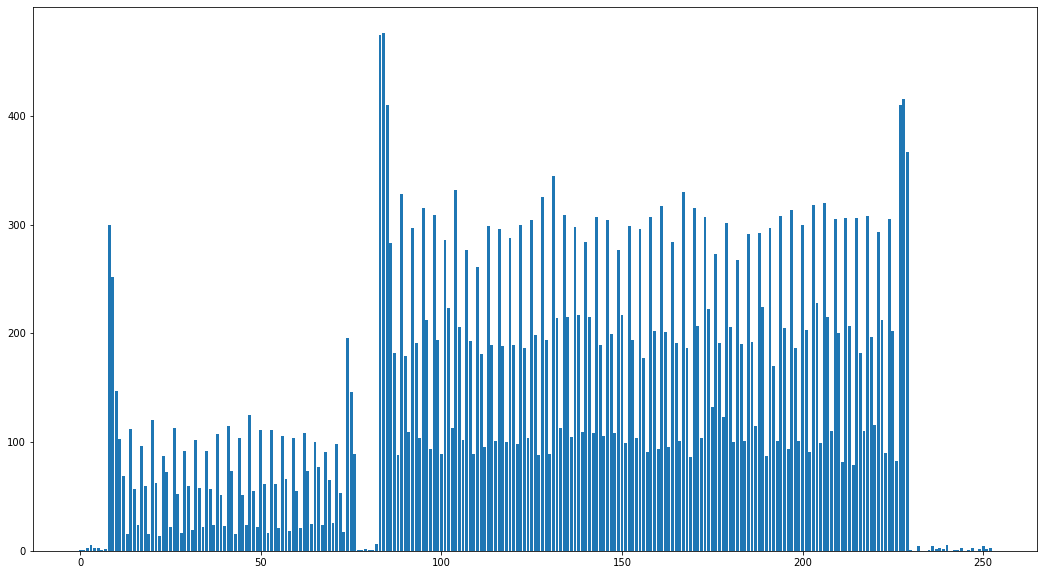

In [10]:
plt.figure(figsize =(18, 10))
plt.bar(np.arange(len(test[1][3])), test[1][3])

<BarContainer object of 69 artists>

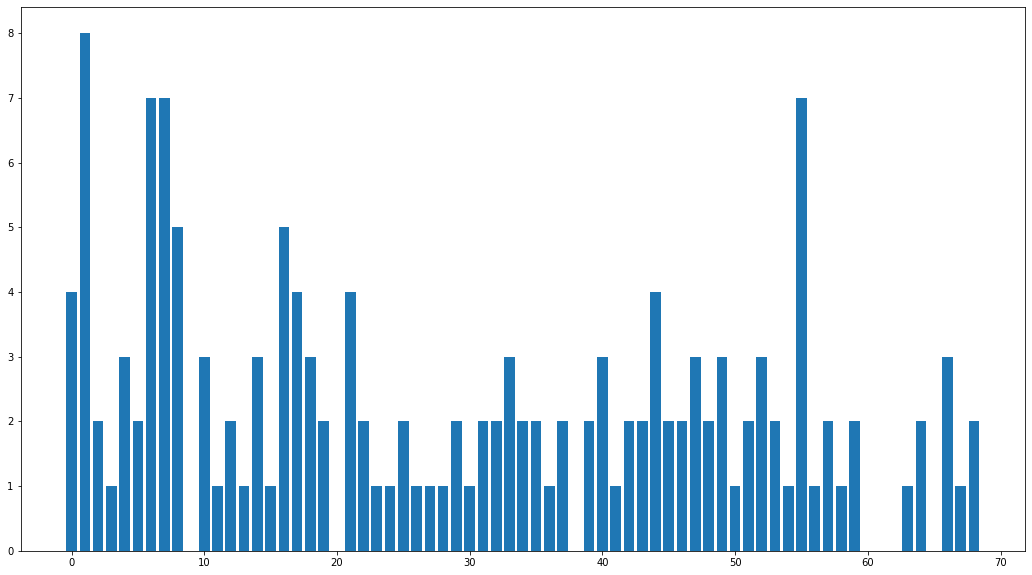

In [11]:
def simulate_neither(length):
    RNA_data = []
    observed_data = []
    state_list_true = []
    for num in range(length):
        curr_observed = []
        curr_state = []
        repeat = random.choices(np.arange(40, 81), weights=np.ones(41), k = 1)[0]
        curr_RNA = random.choices(['A', 'C', 'G', 'U'], weights=np.ones(4), k = repeat)
        for i in range(repeat):
            curr_observed.append(generate_nb(1))
            curr_state.append(1)
        while 'AUG' in "".join(curr_RNA):
            get_index = ("".join(curr_RNA)).index('AUG')
            curr_RNA[get_index] = random.choices(['C', 'G', 'U'], weights=np.ones(3), k = 1)[0]
        RNA_data.append(curr_RNA)
        observed_data.append(curr_observed)
        state_list_true.append(curr_state)
    return (RNA_data, observed_data, state_list_true)
    
        
test = simulate_neither(50)    
plt.figure(figsize =(18, 10))
plt.bar(np.arange(len(test[1][0])), test[1][0])

In [12]:
random.seed(0)
part1 = simulate_sequences(2700) # change bigger later 
part2 = simulate_neither(300) # change bigger later 
RNA_data = part1[0] + part2[0]
observed_data = part1[1] + part2[1]
state_list_true = part1[3] + part2[2]

# shuffle data
c = list(zip(RNA_data, observed_data, state_list_true))
random.shuffle(c)
RNA_data, observed_data, state_list_true = zip(*c)

In [13]:
alpha_init = alpha_list_true
beta_init = beta_list_true
alpha_list = alpha_list_true
beta_list = beta_list_true
trans = {'AUG': [0.5, 0.3, 0.8]}

In [14]:
E = list(np.repeat(1, 100)) # num of sequences each time, change bigger later 
stop_codon_list = ['UAA', 'UGA', 'UAG']
kt = 1

# log-sum-exp

In [15]:
# HMM Notes p17
# log sum(exp(x1)+exp(x2)+...)
# x: list
# result: scalar
def logSumExp(x):
    m = max(x)
    if m == -inf: # infinity
        return -inf
    else:
        minus_m = np.array(x) - m
        result = m + log(sum(np.exp(minus_m)))
        return result   

In [16]:
# examples
# x = list(range(-100,-50))
# log(sum(np.exp(x)))
# logSumExp(x)

# log likelihood f(x)

In [17]:
# Notes p2
# x: scalar. Realization from NB distribution
# alpha, beta: scalar. Parameters from Gamma distribution
# E: list. Normalization factor for n-th sequence
# result: scalar. Log likelihood f(x)
def lnNB(x, alpha, beta, E):
    r = alpha
    p = beta / (E+beta)

    result = nbinom.logpmf(x, r, p) # x follows NB(alpha, beta/(E+beta))
    return result

In [18]:
# examples
# x = 50
# alpha = 1
# beta = 0.1
# E = 10
# lnNB(x, alpha, beta, E)

# Forward

In [442]:
# RNA_data: a list of elements 
# observed_data: height
# trans: dictionary, key: string (start codon); value: three-element list [rho_u, rho, delta]
# alpha_list: a list with length 21 (index 0 to 20)
# beta_list: a list with length 21 (index 0 to 20)
# E: normalizaton factor for each RNA sequence
# stop_codon_list: list of stop codons

In [19]:
def start_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    temp = prob_current[0] +  log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_next[0] = temp
        
    # state 10 and state 11 to state 11     
    log_10_11 = prob_current[9] + log(1) 
    log_11_11 = prob_current[10] + log(1) 
    temp = [log_10_11, log_11_11]
    prob_next[10] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    
    return prob_next

In [20]:
def start_codon_true(i, prob_current, prob_next, trans, next_codon, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    log_1_1 = log_func(1 - trans[next_codon][0] - trans[next_codon][1])
    temp = prob_current[0] + log_1_1  + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_next[0] = temp     
            
    # state 1 to state 2
    log_1_2 = log_func(trans[next_codon][0])
    temp = prob_current[0] + log_1_2 + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E)
    prob_next[1] = temp
            

    # state 1 and state 11 to state 12 
    log_1_12 = prob_current[0] + log_func(trans[next_codon][1])
    log_11_12 = prob_current[10] + log_func(trans[next_codon][2])
    temp = [log_1_12, log_11_12]   
    prob_next[11] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[11], beta_list[11], E)
    
    # state 10 and state 11 to state 11     
    log_10_11 = prob_current[9] + log(1) 
    log_11_11 = prob_current[10] + log_func(1 - trans[next_codon][2])
    temp = [log_10_11, log_11_11]
    prob_next[10] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    
    return prob_next

In [21]:
def stop_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 4 and state 7 to state 5
    log_4_5 = prob_current[3] + log(1) 
    log_7_5 = prob_current[6] + log(1)
    temp = [log_4_5, log_7_5]
    prob_next[4] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
        
    # state 14 and state 17 to state 15
    log_14_15 = prob_current[13] + log(1) 
    log_17_15 = prob_current[16] + log(1) 
    temp = [log_14_15, log_17_15]
    prob_next[14] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
    
    return prob_next

In [22]:
def stop_codon_true(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E):
    
    # state 4 to state 5
    prob_next[4] = prob_current[3] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
        
     # state 7 to state 8
    prob_next[7] = prob_current[6] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    
    # state 14 to 15
    prob_next[14] = prob_current[13] + log(1) + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
   
    # state 17 to state 18
    prob_next[17] = prob_current[16] + log(1) + lnNB(observed_data[i+1], alpha_list[17], beta_list[17], E)
    
    return prob_next

In [23]:
def forward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):

    # Find E and observed_data according the order of sequences
    
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    
    sequence_length = len(RNA_data) # length of data
    output = np.zeros((sequence_length, 21))
    prob_current = np.ones(21) * (-inf) # initialize probability, 21 different states
    prob_current[0] = lnNB(observed_data[0], alpha_list[0], beta_list[0], E)
    output[0] = prob_current
    
    for i in range(sequence_length - 1):
        start_codon = False
        stop_codon = False
        next_codon = ""
        prob_next = np.ones(21) * (-inf)
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
        if next_codon in trans.keys():
            start_codon = True
        if next_codon in stop_codon_list:
            stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            
            prob_next = start_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
        
        # start codon is ture
        elif start_codon == True:   
            prob_next = start_codon_true(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E)
        
        # stop codon is ture
        if stop_codon == True: 

            prob_next = stop_codon_true(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
 
        # stop codon is false
        elif stop_codon == False:

            prob_next = stop_codon_false(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E)
        
       
        # transter to next state with probability 1
        sure_to_transit = [1, 2, 4, 5, 7, 8, 11, 12, 14, 15, 17, 18]
        for k in sure_to_transit:
            temp = prob_current[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k+1], beta_list[k+1], E)
            prob_next[k+1] = temp


        # state 20 and state 21 to state 21     
        log_20_21 = prob_current[19] + log(1) 
        log_21_21 = prob_current[20] + log(1) 
        temp = [log_20_21, log_21_21]
        prob_next[20] = logSumExp(temp) + lnNB(observed_data[i+1], alpha_list[20], beta_list[20], E)
    
        prob_current = prob_next
        output[i+1] = prob_current
  
    return output

In [24]:
def forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = []
    for n in range(1, len(observed_data)+1):
        output.append(forward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, n))
    return output

In [42]:
###
forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)

# Backward

In [448]:
# RNA_data: a list of elements 
# observed_data: height
# trans: dictionary, key: string (start codon); value: three-element list [rho_u, rho, delta]
# alpha_list: a list with length 21 (index 0 to 20)
# beta_list: a list with length 21 (index 0 to 20)
# E: normalizaton factor for each RNA sequence
# stop_codon_list: list of stop codons

In [25]:
def start_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1
    temp = prob_current_back[0] + log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_previous_back[0] = temp
 

    # state 11 to state 11     
    temp = prob_current_back[10] + log(1) + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    prob_previous_back[10] = temp
    
    return prob_previous_back

In [26]:
def start_codon_true_back(i, prob_current_back, prob_previous_back, trans, next_codon, observed_data, alpha_list, beta_list, E):
    
    # state 1 to state 1, 2, 12
    temp = log_func(1 - trans[next_codon][0] - trans[next_codon][1])
    log_1_1 = prob_current_back[0] + temp + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E)
    
    temp = log_func(trans[next_codon][0])
    log_1_2 = prob_current_back[1] + temp + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E) 
    
    
    temp = log_func(trans[next_codon][1]) 
    log_1_12 = prob_current_back[11] + temp + lnNB(observed_data[i+1], alpha_list[11], beta_list[11], E) 
    
    temp = [log_1_1, log_1_2, log_1_12]
    prob_previous_back[0] = logSumExp(temp)
            
            
    # state 11 to state 11, 12
    temp = log_func(1 - trans[next_codon][2])
    log_11_11 = prob_current_back[10] + temp + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E) 
    
    temp = log_func(trans[next_codon][2])
    log_11_12 = prob_current_back[11] + temp + lnNB(observed_data[i+1], alpha_list[11], beta_list[11], E) 
    
    temp = [log_11_11, log_11_12]
    prob_previous_back[10] = logSumExp(temp)
    
    return prob_previous_back

In [27]:
def stop_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 7 to state 5
    prob_previous_back[6] = prob_current_back[4] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
      
    # state 17 to state 15
    prob_previous_back[16] = prob_current_back[14] + log(1) + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
    
    return prob_previous_back

In [28]:
def stop_codon_true_back(i, prob_current_back, prob_previous_back, observed_data, alpha_list, beta_list, E):
    
    # state 7 to state 8
    prob_previous_back[6] = prob_current_back[7] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    
    # state 17 to state 18
    prob_previous_back[16] = prob_current_back[17] + log(1) + lnNB(observed_data[i+1], alpha_list[17], beta_list[17], E)
  
    return prob_previous_back

In [29]:
def backward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):
 
    # Find E and observed_data according the order of sequences
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    sequence_length = len(RNA_data) # length of data
    prob_current_back = list(np.zeros(21)) # initialize probability, 21 different states
    output = np.zeros((sequence_length, 21))
    output[sequence_length - 1] = prob_current_back  
    
    iteration_list = np.arange(0, sequence_length-1, 1).tolist()
    iteration_list.reverse()
    for i in iteration_list:
        start_codon = False
        stop_codon = False
        prob_previous_back = list(np.ones(21) * (-inf))
        next_codon = ""
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
            if next_codon in trans.keys():
                start_codon = True
            if next_codon in stop_codon_list:
                stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            prob_previous_back = start_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                        alpha_list, beta_list, E)
        
        # start codon is true
        elif start_codon == True:   
            prob_previous_back = start_codon_true_back(i, prob_current_back, prob_previous_back, trans, 
                                                       next_codon, observed_data, alpha_list, beta_list, E)
        
        # stop codon is true
        if stop_codon == True: 
            prob_previous_back = stop_codon_true_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                      alpha_list, beta_list, E) 
        
        # stop codon is false
        elif stop_codon == False:
            prob_previous_back = stop_codon_false_back(i, prob_current_back, prob_previous_back, observed_data, 
                                                       alpha_list, beta_list, E)
     
        
        # traster with probability 1
        sure_to_transit = [2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20]
        for k in sure_to_transit:
            temp = prob_current_back[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k], beta_list[k], E)
            prob_previous_back[k-1] = temp


        # state 21 to state 21     
        temp = prob_current_back[20] + log(1) + lnNB(observed_data[i+1], alpha_list[20], beta_list[20], E)
        prob_previous_back[20] = temp    

        prob_current_back = prob_previous_back 
        output[i] = prob_current_back
        
    return output

In [30]:
def backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = []
    for n in range(1, len(observed_data)+1):
        output.append(backward_algorithm(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, n))
    return output

In [ ]:
###
backward =  backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)

# Incomplete log likelihood (simple) with backward

In [31]:
def incomplete_log_likelihood(backward, observed_data, alpha_list, beta_list, E):
   
    # initialize parameters
    temp_list = []
    
    # incomplete log likelihood
    for n in range(1, len(observed_data)+1):
        
        B1_1 = backward[n-1][0][0]
        nb = lnNB(observed_data[n-1][0], alpha_list[0], beta_list[0], E[n-1])
        temp_list.append(B1_1 + nb)
       
    
    output = logSumExp(temp_list)
        
    return output

In [29]:
###
incomplete_log_likelihood(backward, observed_data, alpha_list, beta_list, E)

-86.307127588913

# Incomplete log likelihood (simple) with forward

In [32]:
def incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E):
    # initialize parameters
    
    output_list = []
    # incomplete log likelihood
    for n in range(1, len(observed_data)+1):
    
        last_position = len(observed_data[n-1]) - 1
        output_list.append(logSumExp(forward[n-1][last_position]))
        
    return logSumExp(output_list)

In [31]:
###
incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E)

-86.30712758891303

# Compute L(simple)

In [33]:
def compute_L(forward, backward):
    
    output = []

    for n in range(1, len(forward)+1):
        sequence = np.zeros((len(forward[n-1]), 21))

        for t in range(1, len(forward[n-1])+1):
            
            temp = logSumExp((forward[n-1] + backward[n-1])[t-1])
                   
            sequence[t-1] = forward[n-1][t-1] + backward[n-1][t-1] - temp
            
        output.append(sequence)
    return output

In [44]:
###
L = compute_L(forward, backward)

# Compute H

In [34]:
def transprob_comp(curr_state, next_state, codon_specific):
    if curr_state == 1:
        if next_state == 1:
            return log_func(1 - trans[codon_specific][0] - trans[codon_specific][1])
        elif next_state == 2:
            return log_func(trans[codon_specific][0])
        elif next_state == 12:
            return log_func(trans[codon_specific][1])
    if curr_state == 11:
        if next_state == 11:
            return log_func(1 - trans[codon_specific][2])
        elif next_state == 12:
            return log_func(trans[codon_specific][2])
   

In [35]:
def compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t):
    transprob = transprob_comp(curr_state, next_state, codon_specific)
    numerator = forward[num_sequence - 1][t - 1][curr_state - 1] +\
                transprob + lnNB(observed_data[num_sequence - 1][t], alpha_list[next_state - 1], beta_list[next_state - 1], E[num_sequence - 1]) + \
                backward[num_sequence - 1][t][next_state - 1]
    return numerator

In [36]:
def compute_H_deno(forward, backward, curr_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t):

    output_list = [] 
        
    # case state1 to state1, 2, 12
    if curr_state == 1:
        for next_state in [1, 2, 12]:
            output_list.append(compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t))
    
    # case state11 to state11, 12
    elif curr_state == 11:
        for next_state in [11, 12]:
            output_list.append(compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t))

    return logSumExp(output_list)
        

In [37]:
def compute_H_codon(forward, backward, curr_state, next_state, codon_specific, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, num_sequence):
    
    # initialize parameters
    output = -inf
    numerator_list = []
    # check codon
    if t + 3 <= len(RNA_data[num_sequence - 1]):
        next_codon = RNA_data[num_sequence - 1][t] + RNA_data[num_sequence - 1][t+1] + RNA_data[num_sequence - 1][t+2]  
        
        if codon_specific == next_codon:
   
            numerator = compute_H_nume(forward, backward, curr_state, next_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t)
            if numerator == -inf:
                return -inf
            
    
            denominator = compute_H_deno(forward, backward, curr_state, codon_specific, observed_data, alpha_list, beta_list, num_sequence, t)
        
            output = numerator - denominator
            
            
    return output

# store probabilities

In [38]:
def store_info(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, ci):
    temp = []
    
        
    n11_list = []
    n12_list = []
    n112_list = []
    n1111_list = []
    n1112_list = []
    for n in range(1, len(observed_data) + 1):
            
        for t in range(1, len(observed_data[n-1]) - 1):
            
            n11_list.append(compute_H_codon(forward, backward, 1, 1, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n12_list.append(compute_H_codon(forward, backward, 1, 2, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n112_list.append(compute_H_codon(forward, backward, 1, 12, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n1111_list.append(compute_H_codon(forward, backward, 11, 11, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
            n1112_list.append(compute_H_codon(forward, backward, 11, 12, ci, RNA_data, observed_data, alpha_list, beta_list, E, trans, t, n))
  
    n11 = logSumExp(n11_list)
    n12 = logSumExp(n12_list)
    n112 = logSumExp(n112_list)
    n1111 = logSumExp(n1111_list)
    n1112 = logSumExp(n1112_list)
        
        
    temp.append(np.exp(n11))
    temp.append(np.exp(n12))
    temp.append(np.exp(n112))
    temp.append(np.exp(n1111))
    temp.append(np.exp(n1112))
        
    return temp
                

# three parameters

In [70]:
def update_three_parameters(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output = defaultdict(list)
    for ci in trans.keys():
        
        info = store_info(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, ci)
        
        deno_alpha = info[0]+info[1]+info[2]
        deno_delta = info[3] + info[4]
        
        curr_list = [info[1]/deno_alpha, info[2]/deno_alpha, info[4]/deno_delta]
        output[ci] = curr_list
        
    return output
                
    

In [45]:
###
trans = {'AUG':[0.5, 0.2, 0.8]}

In [47]:
###
update_three_parameters(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)

{'AUG': [0.34887737478411057, 0.6105354058721933, 0.9377917607039187]}

# alpha - M

In [40]:
# Q function with respect to alpha
def object_function_alpha(x, state, forward, observed_data, beta_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #alpha_current = [x] + list(alpha_list[1:])
    #neg_bio = NB_matrix(observed_data, alpha_current, beta_list, E)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  

    #L = compute_L(forward, backward)
    
    output = 0
    
    for n in range(1, len(forward)+1):
        for t in range(1, len(forward[n-1])+1):
            temp = lnNB(observed_data[n-1][t-1], x, beta_list[state-1], E[n-1])
            output += np.exp(L[n-1][t-1][state-1]) * temp
            
        
    return((-1)*output)

In [41]:
#new
def derivative_function_alpha(x, state, forward, observed_data, beta_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  
    #L = compute_L(forward, backward)
        
    output_sum = 0
    for n in range(1, len(observed_data)+1):           
              
        for t in range(1, len(observed_data[n-1])+1):
             
            sum_s = 0
            for s in range(1, observed_data[n-1][t-1]+1):
                    
                sum_s += 1/(x + observed_data[n-1][t-1] - s)
                                 
            latter = sum_s + log(beta_list[state-1] / (E[n-1] + beta_list[state-1]))
                
            output_sum += np.exp(L[n-1][t-1][state-1]) * latter
    
                
    
    return (-1)*output_sum

# beta_correction

In [42]:

def object_function_beta(x, state, forward, observed_data, alpha_list, E, L): # list of alpha_m
    
    #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
    #alpha_current = [x] + list(alpha_list[1:])
    #neg_bio = NB_matrix(observed_data, alpha_current, beta_list, E)
    #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)  

    #L = compute_L(forward, backward)
    
    output = 0
    
    for n in range(1, len(forward)+1):
        for t in range(1, len(forward[n-1])+1):
            temp = lnNB(observed_data[n-1][t-1], alpha_list[state-1], x, E[n-1])
            output += np.exp(L[n-1][t-1][state-1]) * temp
            
        
    return((-1)*output)
        

In [43]:
# new
def derivative_function_beta(x, state, forward, observed_data, alpha_list, E, L): # list of alpha_m
    #forward = forward_matrix(RNA_data, observed_data, alpha_list, x, E, trans, stop_codon_list)

    #neg_bio = NB_matrix(observed_data, alpha_list, x, E)
    #backward = backward_matrix(RNA_data, observed_data, alpha_list, x, E, trans, stop_codon_list) 
    #L = compute_L(forward, backward)
        
    output_sum = 0
    for n in range(1, len(observed_data)+1):
                 
        for t in range(1, len(observed_data[n-1])+1):
                
            first_term = alpha_list[state-1]/x
            second_term = (alpha_list[state-1]+observed_data[n-1][t-1])/(E[n-1]+x)
               
            output_sum += np.exp(L[n-1][t-1][state-1]) * (first_term - second_term)      
           
    return output_sum

# EM iteration

In [298]:
# RNA_data
# observed_data
# E[]
# stop_codon_list,
# kt



def EM_iter(RNA_data, observed_data, trans_init, alpha_init, beta_init, epsilon, max_iter):
    
    trans = trans_init.copy()
    alpha_list = alpha_init.copy()
    beta_list = beta_init.copy()
    
    forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
    backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
    
    log_links = []
    log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_init, beta_init, E))
    
    delta = 1
    n_iter = 1
    print(log_links)
    while((delta > epsilon) and (n_iter < max_iter)):
        print("iteration" + str(n_iter))
        #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        curr_trans = trans.copy()
        curr_alpha_list = alpha_list.copy()
        curr_beta_list = beta_list.copy()
       
        L = compute_L(forward, backward)
        
        #update rho_u_ci, rho_ci, delta_ci
        trans = update_three_parameters(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        print(trans)
        
        # alpha_list
        state_list = np.arange(21)+1
        random.shuffle(state_list)
        
        for i in state_list:
            state = i
           
            print("state"+str(state))
            res = minimize(object_function_alpha, alpha_list[state-1], method='BFGS', tol = 1, jac=derivative_function_alpha, args = (state, forward, observed_data, beta_list, E, L), options={'disp': False, 'maxiter': 10,'gtol': 1})
            alpha_list[state-1] = res.x[0]
            print("alpha"+str(res.x[0]))
            
            res = minimize(object_function_beta, beta_list[state-1], method='nelder-mead', tol = 1, args = (state, forward, observed_data, alpha_list, E, L), options={'disp': False})
            beta_list[state-1] = res.x[0]
            print("beta"+str(res.x[0]))
           
            
        
        print(alpha_list)
        print(beta_list)

        
        forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
        
        # log likelihood
        log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
        delta = log_links[-1] - log_links[-2]
        n_iter += 1
        
        print(log_links)


    if (delta < 0):
        trans = curr_trans
        alpha_list = curr_alpha_list
        beta_list = curr_beta_list
        
    return (trans, alpha_list, beta_list)

# updated

In [299]:
trans_prob = [{'AUG': [0.2, 0.1, 0.3]}, {'AUG': [0.5, 0.2, 0.7]}, {'AUG': [0.8, 0.15, 0.1]}, {'AUG': [0.42, 0.42, 0.5]}]
alpha_list_prob = [np.array([10, 50, 40, 30, 30, 20, 10, 40 , 30, 20, 10, 80, 70, 60, 50, 40 , 30, 60, 50 , 40 , 10]),
            np.array([20, 100, 95, 90, 60, 40, 20, 70 , 66, 50, 10, 200, 180, 150, 100, 90 , 80, 180, 160 , 120 , 10]),
            np.array([1, 150, 110, 90, 50, 30, 10, 100 , 75, 50, 10, 250, 225, 200,150, 100 , 50, 225, 200 , 175, 1])]
beta_list_prob = [beta_init+2, beta_init * 2]

In [300]:
#保存数据
final_trans_copy = final_trans.copy()
final_alpha_list_copy = final_alpha_list.copy()
final_beta_list_copy = final_beta_list.copy()
start_trans_copy = start_trans.copy()
start_alpha_list_copy = start_alpha_list.copy()
start_beta_list_copy = start_beta_list.copy()

In [301]:
final_trans = []
final_alpha_list = []
final_beta_list = []

start_trans = []
start_alpha_list = []
start_beta_list = []

start = 0
count = 1
for end in range(100, 3001, 100):
    print("count " + str(count))
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list.append(alpha_list)
    
    # randomly generate index for beta_list
    random.seed(end+2)
    index = random.choice(range(2))
    beta_list = beta_list_prob[index]
    start_beta_list.append(beta_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    beta_list_copy = beta_list.copy()
    
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], trans_copy, alpha_list_copy, beta_list_copy, 10e-10, 100)
    final_trans.append(temp[0])
    final_alpha_list.append(temp[1])
    final_beta_list.append(temp[2])
    
    start = end
    
    count += 1

count 1
[-169.88420028269212]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.17426815782881586, 0.798978238371656, 0.946064139941691]})
state15
alpha1907.6173508536035
beta6.956250000000001
state11
alpha13.431355042304963
beta6.65
state8
alpha1172.6182856730275
beta5.950000000000001
state2
alpha1805.6835854032968
beta5.950000000000001
state16
alpha1268.7592854847444
beta6.956250000000001
state4
alpha1087.1247973752993
beta5.950000000000001
state17
alpha627.4882334664205
beta6.956250000000001
state3
alpha1277.3543050159988
beta5.775
state9
alpha935.5512424626946
beta6.300000000000001
state1
alpha13.772932157088038
beta6.65
state21
alpha13.822430308204618
beta6.65
state14
alpha2344.048850090224
beta6.65
state7
alpha139.01490090145384
beta6.912500000000001
state10
alpha555.3732498948511
beta5.775
state5
alpha695.9460969605339
beta7.000000000000001
state13
alpha2656.6681241669903
beta6.562500000000001
state19
alpha2335.6075248085126
beta6.65
state18
alpha2635.161060893444
beta6.60625000

alpha193.54446917960706
beta9.750000000000004
state8
alpha1703.0
beta8.393750000000004
state19
alpha3580.9732257871037
beta8.84296875
state9
alpha1122.0
beta7.678125000000005
state10
alpha858.0
beta8.500000000000004
state16
alpha1976.8926871438505
beta9.906250000000004
state13
alpha3780.6821233586356
beta8.550000000000004
state12
alpha4255.067502470742
beta8.550000000000004
state3
alpha1868.0
beta8.393750000000004
state18
alpha3801.8500000000067
beta8.312500000000005
[  18 2300 1868 1585  994  597  193 1703 1122  858   20 4255 3780 3359
 2946 1976  985 3801 3580 3056   19]
[ 9.025       7.75        8.39375     8.875       9.875      10.
  9.75        8.39375     7.678125    8.5         9.75        8.55
  8.55        8.421875    9.84375     9.90625     9.84414063  8.3125
  8.84296875  8.7828125   9.50625   ]
[-78.79444685901349, -78.77295643195293, -78.72015769527505]
iteration3
defaultdict(<class 'list'>, {'AUG': [0.3510311540149187, 0.6059675296182537, 0.9052396878483835]})
state11
al

[-220.09953263842144, -78.95414956186465, -78.97682238203352]
count 6
[-89.79597812118686]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.18081963506118276, 0.7976513431984462, 0.941938814002302]})
state19
alpha3283.0784484786604
beta9.500000000000002
state12
alpha4199.878403203989
beta9.312500000000004
state20
alpha2810.4659683500195
beta9.500000000000002
state3
alpha1738.4000997843277
beta7.875000000000005
state14
alpha3375.1186502769556
beta9.500000000000002
state4
alpha1465.2172201964968
beta8.000000000000005
state5
alpha989.9637042907877
beta9.812500000000004
state8
alpha1642.1672130297318
beta8.000000000000005
state21
alpha19.815537725887562
beta9.500000000000002
state1
alpha19.973116579463753
beta9.500000000000002
state18
alpha3688.106421520591
beta9.375000000000004
state9
alpha1285.986065402683
beta8.000000000000005
state2
alpha2634.2399699668904
beta8.500000000000004
state13
alpha3805.4877433586275
beta9.500000000000002
state7
alpha200.59550628833222
beta9.875000000000004
s

beta5.630625000000001
state2
alpha1779.0
beta5.9193750000000005
state13
alpha2769.2090301155185
beta6.151250000000001
state14
alpha2503.9749890345315
beta6.232187500000001
state19
alpha2448.0216961339183
beta6.070312500000002
state16
alpha1386.6202498277894
beta6.934375000000001
state3
alpha1372.0
beta6.2125
state21
alpha12.762402229762271
beta6.3175
state17
alpha688.433430432449
beta6.869296875000002
[  12 1779 1372 1120  701  423  140 1280  831  655   13 3107 2769 2503
 2077 1386  688 2717 2448 2147   12]
[5.989375   5.919375   6.2125     6.3        6.95625    7.
 7.         6.37875    5.630625   6.3        6.3175     6.2278125
 6.15125    6.2321875  6.934375   6.934375   6.86929688 6.0703125
 6.0703125  6.15125    6.3175    ]
[-75.07519755901328, -71.0224981345144, -71.1338621318937]
count 9
[-94.58430887861765]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.21693069653789013, 0.7509993523230211, 0.9444444444444445]})
state1
alpha20.292952985568434
beta9.750000000000004
state4
al

[-76.67787456295872, -77.0123507830147]
count 12
[-75.10544873335843]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.22811129747460127, 0.7420996108618381, 0.9303403562899555]})
state17
alpha928.5284996366622
beta9.968750000000004
state21
alpha20.020254348177016
beta10.000000000000002
state13
alpha3932.4603073606927
beta9.437500000000004
state19
alpha3476.1858171117615
beta9.500000000000002
state15
alpha2722.2423331910113
beta9.718750000000002
state18
alpha3910.4840182393777
beta9.375000000000004
state4
alpha1456.5220691854643
beta8.250000000000004
state11
alpha19.827163131840756
beta9.500000000000002
state8
alpha1604.142242999282
beta8.125000000000004
state3
alpha1987.9193008471757
beta9.250000000000004
state9
alpha1239.592190645725
beta8.500000000000004
state12
alpha4336.666920511791
beta9.312500000000004
state1
alpha20.134939066711745
beta9.750000000000004
state6
alpha590.3719119010439
beta9.875000000000004
state5
alpha998.2920754177184
beta10.000000000000002
state10
alpha824.057

alpha12.818150354333968
beta5.989375000000001
state12
alpha3027.0
beta6.070312500000001
state8
alpha1165.0
beta5.950000000000001
state6
alpha415.0
beta7.000000000000001
state18
alpha2708.0
beta5.989375000000001
state19
alpha2502.0
beta6.234375
state15
alpha2089.0
beta6.9672216796875
state13
alpha2701.0
beta5.989375000000001
state16
alpha1396.0
beta6.978125
state5
alpha699.0
beta7.000000000000001
[  12 1798 1267 1076  699  415  134 1165  939  653   12 3027 2701 2407
 2089 1396  692 2708 2502 2184   13]
[5.985      5.95       5.775      5.971875   7.         7.
 6.7396875  5.95       6.3        6.475      5.989375   6.0703125
 5.989375   6.02820312 6.96722168 6.978125   6.9125     5.989375
 6.234375   6.2321875  6.48375   ]
[-161.64019874072858, -66.31367476022774, -66.22134495737608, -66.22134495737608]
count 15
[-238.3950774280519]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.23769824973291195, 0.7384684281236248, 0.9620390455531453]})
state6
alpha418.92774631078595
beta7.00000000

[-76.29733624401003, -76.29733624401003]
count 18
[-76.17228983121196]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.21171507572898332, 0.7686903079671511, 0.9596700139836872]})
state5
alpha995.8923706276847
beta10.000000000000002
state11
alpha18.74918190769222
beta9.000000000000004
state8
alpha1648.6407078033471
beta8.125000000000004
state19
alpha3244.3428839835897
beta9.500000000000002
state12
alpha4159.366227231349
beta9.375000000000004
state14
alpha3272.953048822708
beta9.625000000000002
state6
alpha586.8751408295666
beta9.875000000000004
state1
alpha20.056163056624438
beta10.000000000000002
state18
alpha3668.279845865908
beta9.500000000000002
state2
alpha2605.43097520626
beta8.750000000000004
state21
alpha20.517088172695377
beta9.500000000000002
state4
alpha1479.0783375258866
beta8.125000000000004
state3
alpha1734.1265070861614
beta7.875000000000005
state16
alpha1783.3377648733124
beta9.875000000000004
state10
alpha822.609526958403
beta8.250000000000004
state7
alpha199.6525236

alpha1798.8341825208443
beta5.950000000000001
state1
alpha13.896777953446355
beta6.475000000000001
state13
alpha2703.682130580055
beta6.475000000000001
state16
alpha1298.8233817251507
beta6.9671875000000005
state10
alpha564.4312362791251
beta5.6000000000000005
state9
alpha946.2022844765957
beta6.300000000000001
state4
alpha1084.3540696283433
beta5.950000000000001
state19
alpha2422.67050055387
beta6.65
state11
alpha14.340510002202297
beta7.000000000000001
state17
alpha646.7323121638963
beta6.956250000000001
[  13 1798 1274 1084  696  419  138 1174  946  564   14 3026 2703 2430
 1955 1298  646 2741 2422 2126   13]
[6.475     5.95      5.775     5.95      7.        7.        6.825
 5.95      6.3       5.6       7.        6.475     6.475     6.65
 6.978125  6.9671875 6.95625   6.51875   6.65      6.65      6.65     ]
[-200.59875857243773, -78.51952159148638]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.27349623879597845, 0.6884398514295855, 0.9298507537654677]})
state15
alpha2090.5453

[-76.60231286598321, -68.66664740119698]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.3213197969543674, 0.639593908629389, 0.8995363214837713]})
state7
alpha139.9900000000003
beta6.912500000000001
state5
alpha693.9365660314137
beta6.956250000000001
state1
alpha12.797272144148172
beta6.15125
state19
alpha2459.8520115675524
beta6.234375
state3
alpha1232.0
beta5.630625000000001
state10
alpha571.0
beta5.6000000000000005
state17
alpha691.2443499784799
beta6.912500000000001
state12
alpha3127.6264542323956
beta6.1096875
state11
alpha13.391123164702915
beta6.3175
state2
alpha1863.0
beta6.2125
state9
alpha939.0
beta6.300000000000001
state16
alpha1386.9794142241133
beta6.956250000000001
state6
alpha416.0
beta6.956250000000001
state14
alpha2475.135156124283
beta6.152343750000002
state21
alpha12.797587048710446
beta5.989375000000001
state13
alpha2759.777377149259
beta6.070312500000002
state15
alpha2074.629886010001
beta6.912705078125001
state4
alpha1097.0
beta6.098750000000001
state8
alpha113

beta6.912500000000001
state21
alpha14.285385020993461
beta6.825000000000001
state12
alpha3142.5977171554405
beta6.825000000000001
state9
alpha966.6723592520891
beta6.475000000000001
state3
alpha1398.8456825999297
beta6.300000000000001
state20
alpha1965.179420557009
beta6.562500000000001
[  14 2015 1398 1136  696  416  137 1278  966  646   12 3142 2602 2310
 1889 1259  617 2557 2237 1965   14]
[7.      6.65    6.3     6.3     7.      7.      7.      6.3875  6.475
 6.3     6.475   6.825   6.475   6.5625  6.9125  6.95625 6.95625 6.43125
 6.475   6.5625  6.825  ]
[-71.82780702071919, -71.37058287047891]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.3346354166666666, 0.6193576388888888, 0.9003250270855905]})
state17
alpha693.940755362057
beta6.9345117187500005
state10
alpha646.0
beta6.457500000000001
state7
alpha138.0099999999999
beta7.000000000000001
state1
alpha14.1307641905915
beta7.000000000000001
state13
alpha2687.8499999999995
beta5.908437499999999
state3
alpha1398.0
beta6.22125
s

alpha1852.80827813921
beta8.500000000000004
state17
alpha867.4297810755645
beta9.875000000000004
state19
alpha3133.2723245716875
beta9.500000000000002
state5
alpha983.8707124025487
beta10.000000000000002
state14
alpha3070.5210527397676
beta9.625000000000002
state9
alpha1141.994649423952
beta7.500000000000005
state18
alpha3570.046397977721
beta9.562500000000002
state15
alpha2414.3574554956863
beta9.843750000000004
state16
alpha1722.2942560693264
beta9.921875000000004
state1
alpha19.737488788359865
beta9.500000000000002
state11
alpha18.714325719098866
beta9.000000000000004
state6
alpha591.1728091551419
beta9.750000000000004
state4
alpha1585.7961209259659
beta9.000000000000004
state7
alpha197.02941470796006
beta10.000000000000002
state20
alpha2565.9678117303984
beta9.375000000000004
state13
alpha3479.5046664353335
beta9.500000000000002
state12
alpha3924.7377901677705
beta9.500000000000002
state21
alpha19.614788393403586
beta9.750000000000002
state2
alpha2355.1071759417246
beta7.7500000000

In [302]:
final_trans

[defaultdict(list,
             {'AUG': [0.27578956213772726,
               0.6875263033145247,
               0.924198250728863]}),
 defaultdict(list,
             {'AUG': [0.21377095187087444,
               0.7575253788028733,
               0.9559688058698959]}),
 defaultdict(list,
             {'AUG': [0.3510311540149187,
               0.6059675296182537,
               0.9052396878483835]}),
 defaultdict(list,
             {'AUG': [0.20431841460231925,
               0.7574892325064004,
               0.9402810304449736]}),
 defaultdict(list,
             {'AUG': [0.26159713444424715,
               0.7137285249039825,
               0.9438202247191011]}),
 defaultdict(list,
             {'AUG': [0.3091001527028009,
               0.652770716641378,
               0.9221183800623053]}),
 defaultdict(list,
             {'AUG': [0.21301164023118802,
               0.7560975609760833,
               0.9157894736842106]}),
 defaultdict(list,
             {'AUG': [0.2027694530556980

# Viterbi

In [201]:
def start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output):
    
    # state 1 to state 1
    temp = prob_current[0] +  log(1) + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_next[0] = temp
    output[i+1][0] = 1
        
    # state 10 and state 11 to state 11     
    log_10_11 = prob_current[9] + log(1) 
    log_11_11 = prob_current[10] + log(1) 
    if log_10_11 > log_11_11:
        output[i+1][10] = 10
    else:
        output[i+1][10] = 11
    temp = max(log_10_11, log_11_11)
    prob_next[10] = temp + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    
    return (prob_next, output)

In [202]:
def start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, alpha_list, beta_list, E, output):
    
    # state 1 to state 1
    log_1_1 = log_func(1 - trans[next_codon][0] - trans[next_codon][1])
    temp = prob_current[0] + log_1_1  + lnNB(observed_data[i+1], alpha_list[0], beta_list[0], E) 
    prob_next[0] = temp   
    output[i+1][0] = 1
            
    # state 1 to state 2
    log_1_2 = log_func(trans[next_codon][0])
    temp = prob_current[0] + log_1_2 + lnNB(observed_data[i+1], alpha_list[1], beta_list[1], E)
    prob_next[1] = temp
    output[i+1][1] = 1         

    # state 1 and state 11 to state 12 
    log_1_12 = prob_current[0] + log_func(trans[next_codon][1])
    log_11_12 = prob_current[10] + log_func(trans[next_codon][2])
    if log_1_12 > log_11_12:
        output[i+1][11] = 1
    else:
        output[i+1][11] = 11
    temp = max(log_1_12, log_11_12) 
    prob_next[11] = temp + lnNB(observed_data[i+1], alpha_list[11], beta_list[11], E)
    
    # state 10 and state 11 to state 11     
    log_10_11 = prob_current[9] + log(1) 
    log_11_11 = prob_current[10] + log_func(1 - trans[next_codon][2])
    if log_10_11 > log_11_11:
        output[i+1][10] = 10
    else:
        output[i+1][10] = 11
    temp = max(log_10_11, log_11_11)
    prob_next[10] = temp + lnNB(observed_data[i+1], alpha_list[10], beta_list[10], E)
    
    return (prob_next, output)

In [203]:
def stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output):
    
    # state 4 and state 7 to state 5
    log_4_5 = prob_current[3] + log(1) 
    log_7_5 = prob_current[6] + log(1)
    if log_4_5 > log_7_5:
        output[i+1][4] = 4
    else:
        output[i+1][4] = 7
    temp = max(log_4_5, log_7_5)
    prob_next[4] = temp + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
        
    # state 14 and state 17 to state 15
    log_14_15 = prob_current[13] + log(1) 
    log_17_15 = prob_current[16] + log(1) 
    if log_14_15 > log_17_15:
        output[i+1][14] = 14
    else:
        output[i+1][14] = 17
    temp = max(log_14_15, log_17_15)
    prob_next[14] = temp + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
    
    return (prob_next, output)

In [204]:
def stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E,output):
    
    # state 4 to state 5
    prob_next[4] = prob_current[3] + log(1) + lnNB(observed_data[i+1], alpha_list[4], beta_list[4], E)
    output[i+1][4] = 4
        
     # state 7 to state 8
    prob_next[7] = prob_current[6] + log(1) + lnNB(observed_data[i+1], alpha_list[7], beta_list[7], E)
    output[i+1][7] = 7
    
    # state 14 to 15
    prob_next[14] = prob_current[13] + log(1) + lnNB(observed_data[i+1], alpha_list[14], beta_list[14], E)
    output[i+1][14] = 14
    # state 17 to state 18
    prob_next[17] = prob_current[16] + log(1) + lnNB(observed_data[i+1], alpha_list[17], beta_list[17], E)
    output[i+1][17] = 17
    return (prob_next, output)

In [205]:
def viterbi(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, num_sequence):

    # Find E and observed_data according the order of sequences
    
    E = E[num_sequence - 1]
    observed_data = observed_data[num_sequence - 1]
    RNA_data = RNA_data[num_sequence - 1]
    
    
    sequence_length = len(RNA_data) # length of data
    output = np.zeros((sequence_length, 21))
    prob_current = np.ones(21) * (-inf) # initialize probability, 21 different states
    prob_current[0] = lnNB(observed_data[0], alpha_list[0], beta_list[0], E)
    
    for i in range(sequence_length - 1):
        start_codon = False
        stop_codon = False
        next_codon = ""
        prob_next = np.ones(21) * (-inf)
        
        # Check start and stop codon
        if i + 3 < sequence_length:
            next_codon = RNA_data[i+1] + RNA_data[i+2] + RNA_data[i+3]  
        if next_codon in trans.keys():
            start_codon = True
        if next_codon in stop_codon_list:
            stop_codon = True
        
        # start codon is false
        if start_codon == False:       
            
            prob_next = start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = start_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
         
        # start codon is ture
        elif start_codon == True:   
            prob_next = start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E, output)[0]
            output = start_codon_true_viterbi(i, prob_current, prob_next, trans, next_codon, observed_data, 
                                           alpha_list, beta_list, E, output)[1]
        
        # stop codon is ture
        if stop_codon == True: 

            prob_next = stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = stop_codon_true_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
 
        # stop codon is false
        elif stop_codon == False:

            prob_next = stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[0]
            output = stop_codon_false_viterbi(i, prob_current, prob_next, observed_data, alpha_list, beta_list, E, output)[1]
        
       
        # transter to next state with probability 1
        sure_to_transit = [1, 2, 4, 5, 7, 8, 11, 12, 14, 15, 17, 18]
        for k in sure_to_transit:
            temp = prob_current[k] + log(1) + lnNB(observed_data[i+1], alpha_list[k+1], beta_list[k+1], E)
            prob_next[k+1] = temp
            output[i+1][k+1] = k+1


        # state 20 and state 21 to state 21     
        log_20_21 = prob_current[19] + log(1) 
        log_21_21 = prob_current[20] + log(1) 
        if log_20_21 > log_21_21:
            output[i+1][20] = 20
        else:
            output[i+1][20] = 21
        temp = max(log_20_21, log_21_21)
        prob_next[20] = temp + lnNB(observed_data[i+1], alpha_list[20], beta_list[20], E)
    
        prob_current = prob_next
        
    
    output_list = [list(prob_current).index(max(prob_current))+1]
    start = len(output) - 1
    while start >= 1:
        index = int(output_list[-1] - 1)
        current = int(output[start][index])
        output_list.append(current)
        start -= 1
    
    output_list.reverse()
    return output_list

In [206]:
def viterbi_sequence(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list):
    output_list = []
    for i in range(len(RNA_data)):
        output_list.append(viterbi(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, i+1))
    return output_list

In [207]:
def differ_state(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list, state_list_true):
    start = 0
    differ_list = []
    
    for end in range(100, 3001, 100):
        count = 0
        viterbi_output = viterbi_sequence(RNA_data[start:end], observed_data[start:end], 
                                          alpha_list[int(start/100)], beta_list[int(start/100)], 
                                          E, trans[int(start/100)], stop_codon_list) #correction
        
        curr_state = state_list_true[start:end]
        for i in range(len(curr_state)):
            for j in range(len(curr_state[i])):
                if viterbi_output[i][j] != curr_state[i][j]:
                    count += 1
        
        differ_list.append(count)
        start += 100
    
    return differ_list

In [309]:
#new

before = differ_state(RNA_data, observed_data, start_alpha_list, start_beta_list, E, start_trans, stop_codon_list, state_list_true)
after = differ_state(RNA_data, observed_data, final_alpha_list, final_beta_list, E, final_trans, stop_codon_list, state_list_true)
after

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1955,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 3034,
 0,
 0,
 0,
 2,
 0,
 4433,
 0,
 0]

In [210]:
before

[2440,
 1272,
 3861,
 3799,
 2648,
 2646,
 1648,
 3528,
 2429,
 3122,
 1955,
 1942,
 2874,
 1848,
 2952,
 2849,
 3166,
 3126,
 2741,
 1753,
 2486,
 3034,
 3782,
 3542,
 2622,
 2703,
 3509,
 4433,
 2719,
 2905]

In [211]:
final_alpha_list

[array([  13, 1805, 1277, 1087,  695,  424,  139, 1172,  935,  555,   13,
        2978, 2741, 2429, 2089, 1385,  695, 2720, 2420, 2335,   13]),
 array([  20, 2638, 1745, 1463,  999,  591,  197, 1616, 1261,  836,   21,
        4397, 3931, 3498, 2774, 1888,  953, 4005, 3597, 3138,   20]),
 array([  17, 2300, 1868, 1585,  994,  597,  193, 1703, 1122,  858,   20,
        4255, 3780, 3359, 2946, 1976,  985, 3801, 3580, 3056,   17]),
 array([  20, 2329, 1881, 1327,  991,  593,  198, 1679, 1137,  832,   18,
        3949, 3476, 3060, 2453, 1729,  870, 3620, 3218, 2721,   19]),
 array([  20, 2648, 1888, 1584,  995,  595,  199, 1745, 1356,  852,   20,
        4294, 3791, 3357, 2673, 1788,  887, 3823, 3394, 2681,   19]),
 array([  19, 2634, 1738, 1465,  989,  589,  198, 1642, 1285,  807,   19,
        4199, 3805, 3375, 2912, 1975,  988, 3688, 3283, 2895,   18]),
 array([  14, 1799, 1267, 1086,  699,  420,  138, 1162,  930,  658,   14,
        3051, 2753, 2462, 1976, 1311,  651, 2743, 2428, 2114, 

In [332]:
alpha_name_list = []
for i in range(1, 22):
    alpha_name_list.append(str(i))
    
beta_name_list = []
for i in range(1, 22):
    beta_name_list.append(str(i))


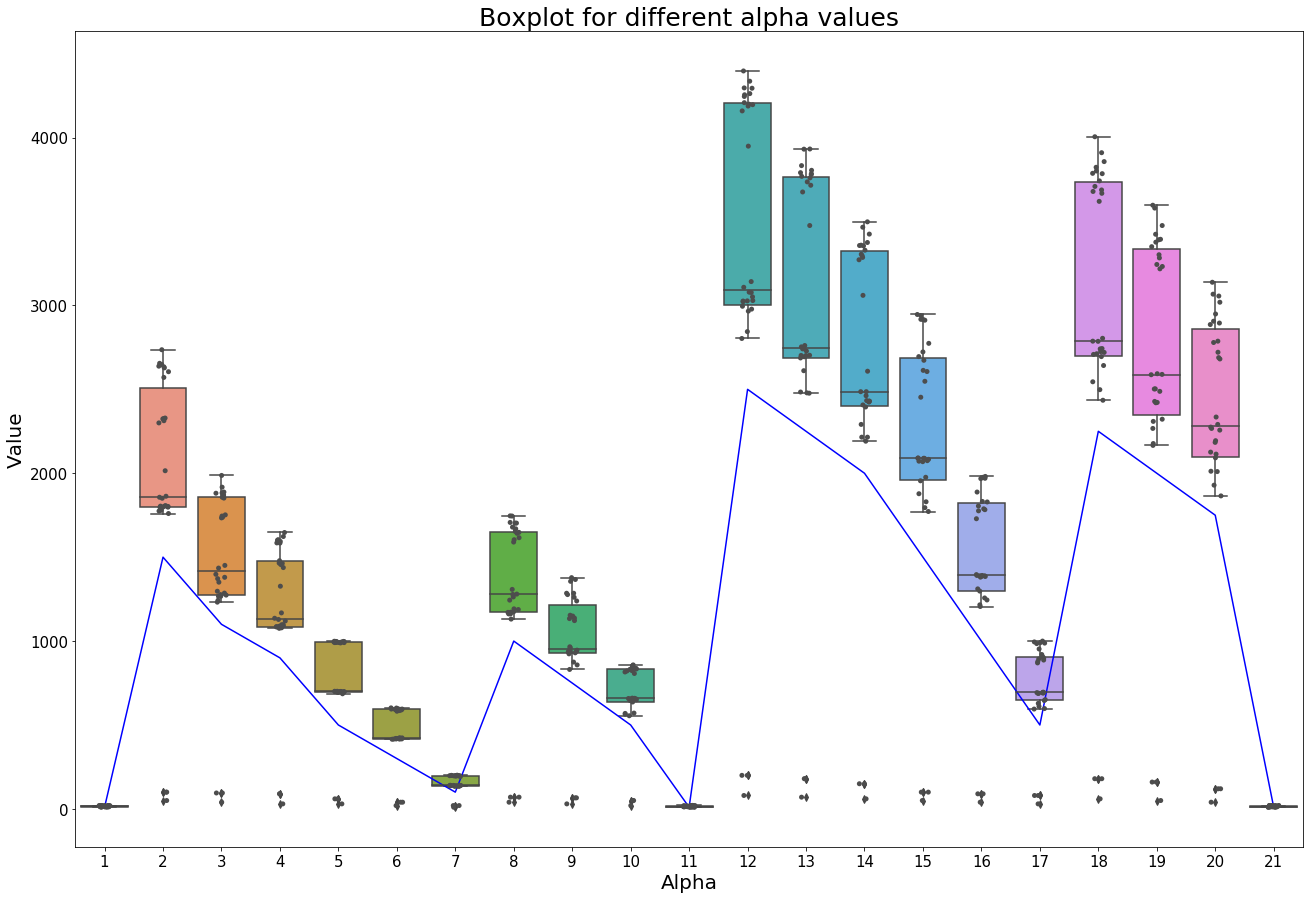

In [335]:
# construct final alpha dataframe
final_alpha_df = pd.DataFrame(final_alpha_list, columns=alpha_name_list)

fig, ax = plt.subplots(figsize = (22,15))
sns.boxplot(data=final_alpha_df)
sns.stripplot(data=final_alpha_df, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, alpha_init, 'b-')

# label
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Value', fontsize = 20)
plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)
plt.title('Boxplot for different alpha values', fontsize = 25) 
fig.savefig("Boxplot for different alpha values")

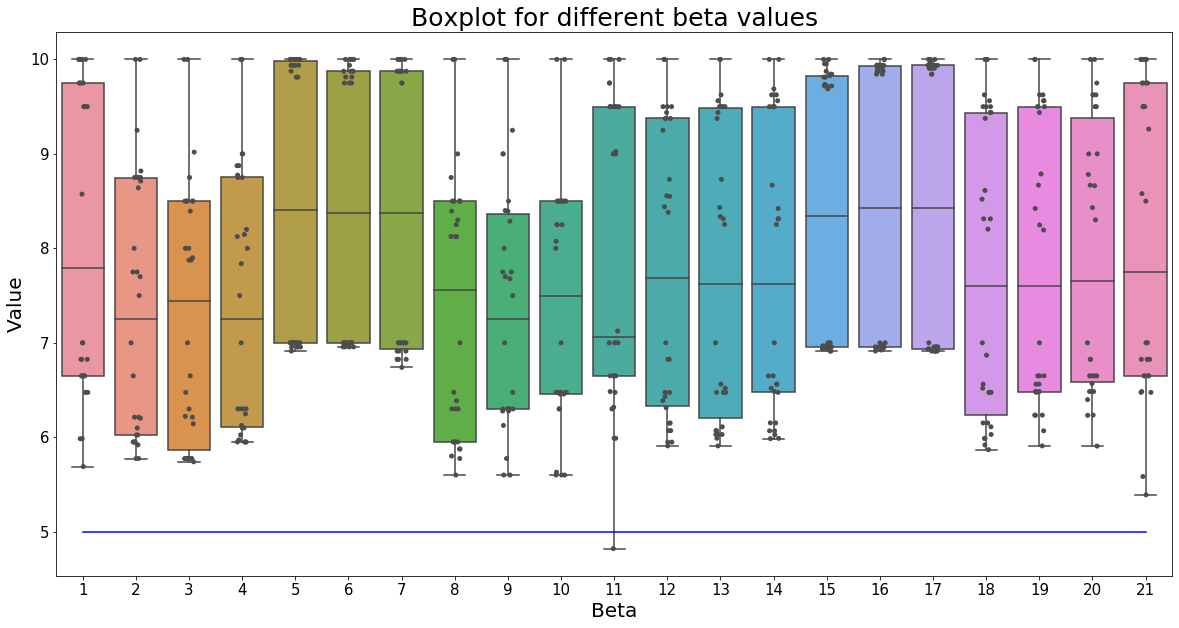

In [336]:
# construct final beta dataframe
final_beta_df = pd.DataFrame(final_beta_list, columns=beta_name_list)

fig, ax = plt.subplots(figsize = (20,10))
sns.boxplot(data=final_beta_df)
sns.stripplot(data=final_beta_df, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, beta_init, 'b-')

# label
plt.xlabel('Beta', fontsize = 20)
plt.ylabel('Value', fontsize = 20)
#plt.rc('xtick',labelsize = 12)
#plt.rc('ytick',labelsize = 12)
plt.title('Boxplot for different beta values', fontsize = 25) 
fig.savefig("Boxplot for different beta values")

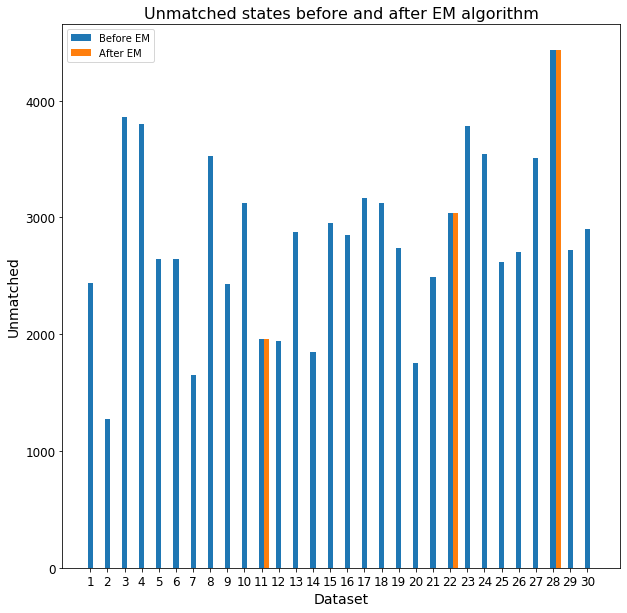

In [340]:
# plot
fig, ax = plt.subplots(figsize = (10,10))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3

# label
plt.bar(ind, before, width, label = 'Before EM')
plt.bar(ind + width, after, width, label = 'After EM') 
plt.xlabel('Dataset', fontsize = 14)
plt.ylabel('Unmatched', fontsize = 14)
plt.rc('xtick',labelsize = 12)
plt.rc('ytick',labelsize = 12)
plt.title('Unmatched states before and after EM algorithm', fontsize = 16) 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm")

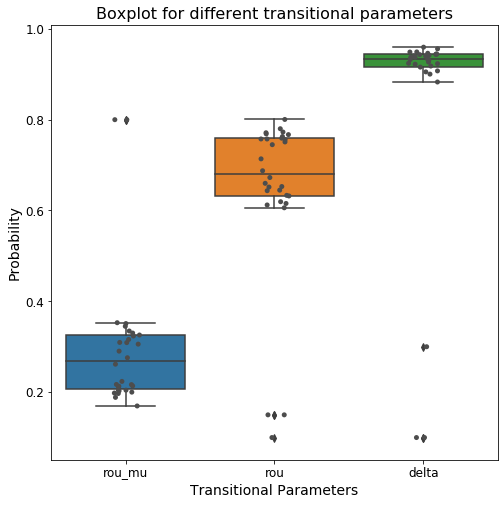

In [341]:
rou_mu = []
rou = []
delta = []
for element in final_trans:
    rou_mu.append(element['AUG'][0])
    rou.append(element['AUG'][1])
    delta.append(element['AUG'][2])
    
final_trans_df = pd.DataFrame({"rou_mu":rou_mu, "rou":rou,"delta": delta}, 
                                         columns=['rou_mu', 'rou', 'delta'])

fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(data=final_trans_df)
sns.stripplot(data=final_trans_df, color=".3", size=5)


plt.xlabel('Transitional Parameters', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.title('Boxplot for different transitional parameters', fontsize = 16) 
fig.savefig("Boxplot for different transitional parameters")



In [232]:
final_alpha_df_remove = pd.DataFrame(final_alpha_list, columns=alpha_name_list)
final_alpha_df_remove = final_alpha_df_remove.drop([10, 21, 27])

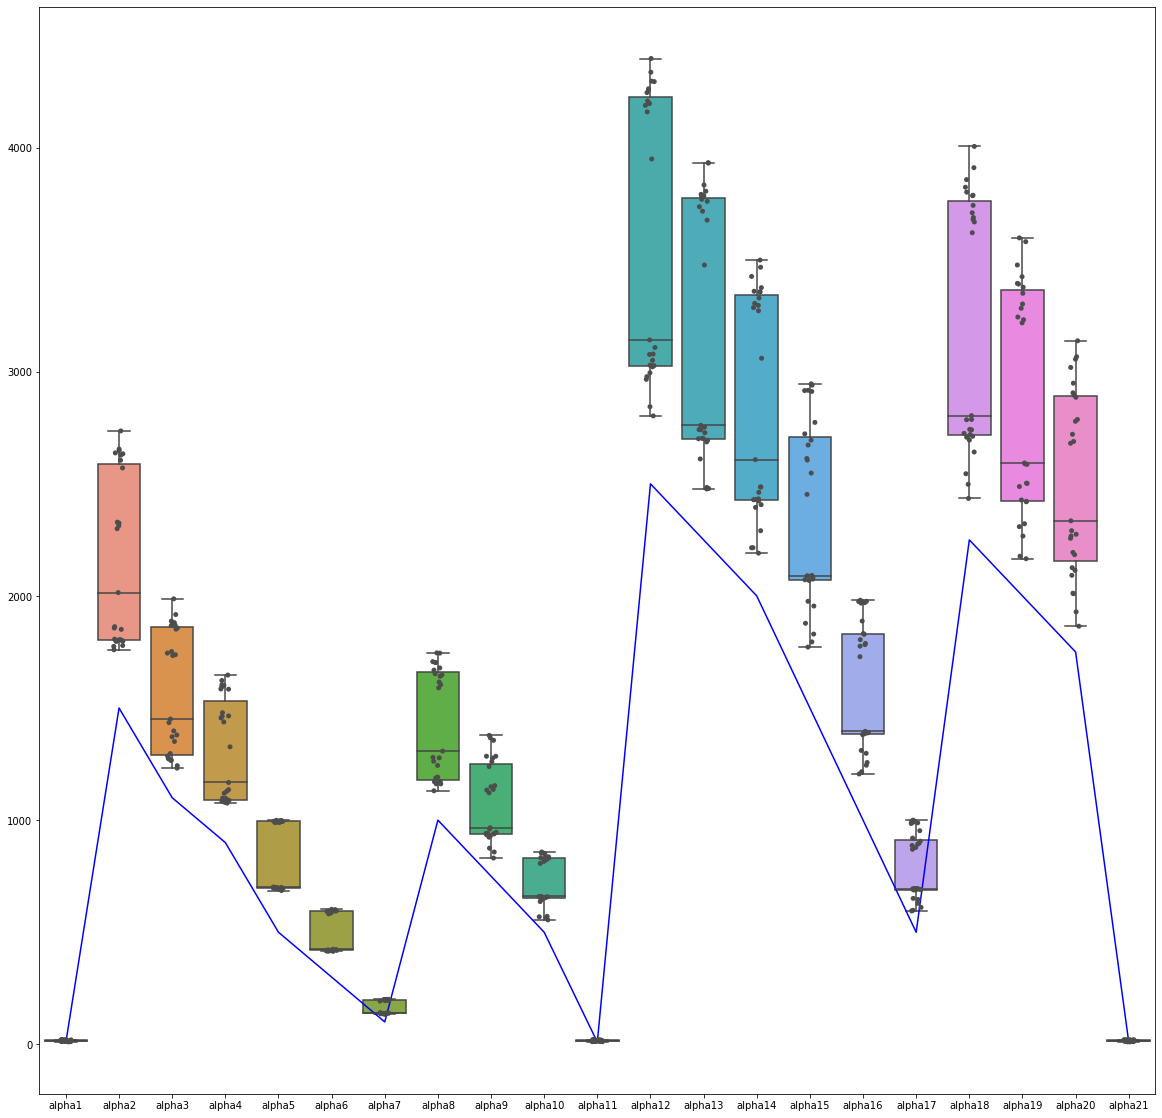

In [236]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (20,20))
sns.boxplot(data=final_alpha_df_remove)
sns.stripplot(data=final_alpha_df_remove, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, alpha_init, 'b-')

In [240]:
final_alpha_df_small = final_alpha_df_remove.loc[:,['alpha1', 'alpha11', 'alpha21']]

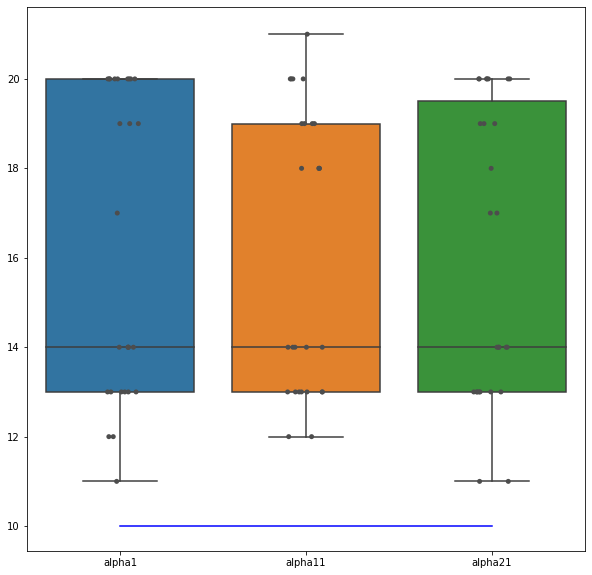

In [244]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(data=final_alpha_df_small)
sns.stripplot(data=final_alpha_df_small, color=".3", size=5)

locs=ax.get_xticks()
ax.plot(locs, [alpha_init[0], alpha_init[10], alpha_init[20]], 'b-')

In [256]:
final_tran_df = 

[0.27578956213772726,
 0.21377095187087444,
 0.3510311540149187,
 0.20431841460231925,
 0.26159713444424715,
 0.3091001527028009,
 0.21301164023118802,
 0.20276945305569802,
 0.21693069653789013,
 0.31594344222330567,
 0.2,
 0.3057247250720056,
 0.21655840705669946,
 0.290308173291648,
 0.3528884908195296,
 0.3236151518853748,
 0.19803459591171663,
 0.21171507572898332,
 0.33013698630137,
 0.18845471328913124,
 0.22360100058563653,
 0.8,
 0.16954731248216057,
 0.32582654528030663,
 0.3346354166666666,
 0.30950266428143264,
 0.3449691991786448,
 0.8,
 0.1970101018712331,
 0.20381931534491443]

# beta fixed

In [ ]:
trans_prob = [{'AUG': [0.2, 0.1, 0.3]}, {'AUG': [0.5, 0.2, 0.7]}, {'AUG': [0.8, 0.15, 0.1]}, {'AUG': [0.42, 0.42, 0.5]}]
alpha_list_prob = [np.array([10, 50, 40, 30, 30, 20, 10, 40 , 30, 20, 10, 80, 70, 60, 50, 40 , 30, 60, 50 , 40 , 10]),
            np.array([20, 100, 95, 90, 60, 40, 20, 70 , 66, 50, 10, 200, 180, 150, 100, 90 , 80, 180, 160 , 120 , 10]),
            np.array([1, 150, 110, 90, 50, 30, 10, 100 , 75, 50, 10, 250, 225, 200,150, 100 , 50, 225, 200 , 175, 1])]


In [259]:
final_trans_beta_fixed = []
final_alpha_list_beta_fixed = []
#final_beta_list = []

start_trans_beta_fixed = []
start_alpha_list_beta_fixed = []
#start_beta_list = []

start = 0
count = 1
for end in range(100, 3001, 100):
    print("count " + str(count))
    
    trans_prob_copy = trans_prob.copy()
    # randomly generate index for trans
    random.seed(end)
    index = random.choice(range(4))
    trans = trans_prob_copy[index]
    start_trans_beta_fixed.append(trans)
    
    # randomly generate index for alpha_list
    random.seed(end+1)
    index = random.choice(range(3))
    alpha_list = alpha_list_prob[index]
    start_alpha_list_beta_fixed.append(alpha_list)
    
    # randomly generate index for beta_list
    #random.seed(end+2)
    #index = random.choice(range(2))
    #beta_list = beta_list_prob[index]
    #start_beta_list.append(beta_list)
    
    # run EM algorithm
    trans_copy = trans.copy()
    alpha_list_copy = alpha_list.copy()
    #beta_list_copy = beta_list.copy()
    
    temp = EM_iter(RNA_data[start:end], observed_data[start:end], trans_copy, alpha_list_copy, beta_init, 10e-10, 100)
    final_trans_beta_fixed.append(temp[0])
    final_alpha_list_beta_fixed.append(temp[1])
    #final_beta_list.append(temp[2])
    
    start = end
    
    count += 1

count 1
[-149.20650345169142]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.17341591233921225, 0.7989518818484996, 0.9446064139941691]})
state11
alpha9.704602972776524
state16
alpha904.6850463033081
state13
alpha1976.3070205371282
state1
alpha9.893055632427904
state20
alpha1431.4652548745519
state9
alpha646.1617379669683
state3
alpha1014.9721192677802
state17
alpha447.05569239595695
state19
alpha1723.9215700970594
state6
alpha303.0279342535016
state14
alpha1731.2373592166778
state8
alpha923.9562395262734
state5
alpha496.636098800726
state4
alpha851.0683733668286
state10
alpha443.8033709334449
state21
alpha9.888441900614554
state2
alpha1414.2270518284095
state15
alpha1360.1988624670219
state12
alpha2232.4714997808906
state18
alpha1959.1216907654489
state7
alpha100.06534087037495
[   9 1414 1014  851  496  303  100  923  646  443    9 2232 1976 1731
 1360  904  447 1959 1723 1431    9]
[-149.20650345169142, -68.58701760723255]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.2763220

alpha1980.7320691913055
state18
alpha2223.279783056256
state3
alpha1007.0
state9
alpha711.0
state8
alpha928.0
state10
alpha462.0499999999999
state4
alpha838.0
state14
alpha1905.0858926816193
state11
alpha10.0
state21
alpha10.051918654009757
state17
alpha501.2768829403676
state2
alpha1400.0
state6
alpha300.0100000000001
state12
alpha2488.2981464651434
state13
alpha2225.081630045797
state7
alpha100.0
state5
alpha500.0
state15
alpha1500.7752240289356
state1
alpha10.455399899596589
[  10 1400 1007  838  500  300  100  928  711  462   10 2488 2225 1905
 1500  999  501 2223 1980 1696   10]
[-169.4628217074085, -79.58030286086245, -79.58030286086245]
count 6
[-76.84194369839973]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.1762822736740652, 0.7957606816404632, 0.9361370716510904]})
state16
alpha894.8451484614214
state3
alpha934.0476890305908
state20
alpha1424.9688684213968
state5
alpha499.94801000979254
state21
alpha9.928427384569448
state7
alpha100.71629372851807
state11
alpha10.4011677

alpha912.0
state14
alpha1966.9778870653915
state17
alpha499.4548720408511
state13
alpha2195.327619070012
state4
alpha846.0
state21
alpha10.206590129840684
state11
alpha10.25358031593883
state1
alpha10.303049160622093
state18
alpha2207.616548848631
state12
alpha2339.8500000000004
state19
alpha1981.4888656451255
state20
alpha1662.145042862686
state2
alpha1435.0
state10
alpha458.04999999999995
state7
alpha99.0100000000001
[  10 1435 1018  846  497  298   99  912  711  458   10 2339 2195 1966
 1495  999  499 2207 1981 1662   10]
[-101.8827091549912, -76.12225867119224, -76.12225867119224]
count 12
[-68.61458501551044]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.22337158757300266, 0.7396234185950373, 0.9275634995734156]})
state10
alpha447.92244203728075
state11
alpha10.0
state14
alpha1772.432722713086
state3
alpha1047.2895960511341
state8
alpha965.6261621687245
state18
alpha2011.743248552568
state21
alpha10.031291401173737
state9
alpha667.2580580770289
state20
alpha1538.4030691403564


alpha9.838056077431142
state13
alpha2241.62274560767
state15
alpha1499.4035195625122
state14
alpha1962.6343775034554
state5
alpha500.0
state19
alpha1974.2399303682253
state11
alpha10.286690088244704
state12
alpha2495.883482280604
state16
alpha997.7901278571743
state8
alpha894.0
[   9 1432  994  851  500  298  100  894  701  458   10 2495 2241 1962
 1499  997  501 2196 1974 1701   10]
[-112.76083310029567, -74.81836734928567, -74.81836734928567]
count 17
[-99.97717334243025]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.20293847565526243, 0.7653604739438182, 0.9360100376267234]})
state14
alpha1701.2608333641729
state21
alpha10.133652525365571
state17
alpha433.59055240337204
state11
alpha10.0
state2
alpha1422.47303582716
state19
alpha1648.3105958839124
state20
alpha1389.5536240139559
state12
alpha2186.1535184617105
state7
alpha99.18573862333879
state10
alpha446.3076949744785
state5
alpha500.5260499372915
state3
alpha1008.9442492197202
state9
alpha711.5408324948046
state18
alpha1888.9

alpha2184.1838783412823
[   9 1405 1024  861  498  299   99  928  637  444    9 2184 1922 1616
 1345  901  444 1971 1625 1412   10]
[-151.18058398417264, -70.66913311655158]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.3184744922027038, 0.6453689946719866, 0.9274193548387096]})
state7
alpha99.0
state1
alpha9.772712857360967
state17
alpha499.6531211882462
state21
alpha10.695293539504453
state16
alpha999.0696905100418
state4
alpha861.0
state2
alpha1405.0
state3
alpha1024.0
state14
alpha1906.465597968949
state11
alpha9.768381744874159
state5
alpha498.0
state18
alpha2230.8385456118235
state13
alpha2203.3900879360413
state9
alpha707.2362580680112
state8
alpha928.0
state15
alpha1499.3039109450908
state6
alpha299.0
state10
alpha449.05000000000007
state19
alpha1916.426991558195
state12
alpha2459.1452185658554
state20
alpha1691.2334306701157
[   9 1405 1024  861  498  299   99  928  707  449    9 2459 2203 1906
 1499  999  499 2230 1916 1691   10]
[-151.18058398417264, -70.66913311655158, 

[-144.37818971705963, -71.40356672719946]
iteration2
defaultdict(<class 'list'>, {'AUG': [0.3095026641638099, 0.6598579040852574, 0.9324796274738066]})
state13
alpha2232.1513043461587
state12
alpha2511.6765714185167
state10
alpha456.0
state19
alpha1967.2802240477615
state3
alpha1034.0
state5
alpha496.0
state17
alpha499.912665146005
state15
alpha1497.3291610226902
state4
alpha852.0
state11
alpha10.288451366513941
state2
alpha1416.0
state20
alpha1683.9327263472046
state14
alpha1977.431918081933
state18
alpha2231.4574251948507
state9
alpha719.2197540683559
state8
alpha938.0
state6
alpha299.0
state1
alpha9.841846090642264
state16
alpha998.9748998391935
state21
alpha9.810385535687889
state7
alpha100.00999999999988
[   9 1416 1034  852  496  299  100  938  719  456   10 2511 2232 1977
 1497  998  499 2231 1967 1683    9]
[-144.37818971705963, -71.40356672719946, -71.40356672719946]
count 27
[-99.49253167961757]
iteration1
defaultdict(<class 'list'>, {'AUG': [0.18788501026693208, 0.7828541944

In [258]:
def EM_iter(RNA_data, observed_data, trans_init, alpha_init, beta_init, epsilon, max_iter):
    
    trans = trans_init.copy()
    alpha_list = alpha_init.copy()
    beta_list = beta_init
    #beta_list = beta_init.copy()
    
    forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
    backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
    
    log_links = []
    log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
    
    delta = 1
    n_iter = 1
    print(log_links)
    while((delta > epsilon) and (n_iter < max_iter)):
        print("iteration" + str(n_iter))
        #forward = forward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        #backward = backward_matrix(RNA_data, observed_data, x, beta_list, E, trans, stop_codon_list)
        curr_trans = trans.copy()
        curr_alpha_list = alpha_list.copy()
        #curr_beta_list = beta_list.copy()
       
        L = compute_L(forward, backward)
        
        #update rho_u_ci, rho_ci, delta_ci
        trans = update_three_parameters(forward, backward, RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        print(trans)
        
        # alpha_list
        state_list = np.arange(21)+1
        random.shuffle(state_list)
        
        for i in state_list:
            state = i
           
            print("state"+str(state))
            res = minimize(object_function_alpha, alpha_list[state-1], method='BFGS', tol = 1, jac=derivative_function_alpha, args = (state, forward, observed_data, beta_list, E, L), options={'disp': False, 'maxiter': 10,'gtol': 1})
            alpha_list[state-1] = res.x[0]
            print("alpha"+str(res.x[0]))
            
            #res = minimize(object_function_beta, beta_list[state-1], method='nelder-mead', tol = 1, args = (state, forward, observed_data, alpha_list, E, L), options={'disp': False})
            #beta_list[state-1] = res.x[0]
            #print("beta"+str(res.x[0]))
           
            
        
        print(alpha_list)
        #print(beta_list)

        
        forward = forward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)
        backward = backward_matrix(RNA_data, observed_data, alpha_list, beta_list, E, trans, stop_codon_list)  
        
        # log likelihood
        log_links.append(incomplete_log_likelihood(forward, observed_data, alpha_list, beta_list, E))
        delta = log_links[-1] - log_links[-2]
        n_iter += 1
        
        print(log_links)


    if (delta < 0):
        trans = curr_trans
        alpha_list = curr_alpha_list
        #beta_list = curr_beta_list
        
    return (trans, alpha_list)

In [260]:
final_trans_beta_fixed

[defaultdict(list,
             {'AUG': [0.27632205823846967,
               0.6869938065745592,
               0.9198250728862973]}),
 defaultdict(list,
             {'AUG': [0.2099375858172953,
               0.7570168785802464,
               0.9513574660639245]}),
 defaultdict(list,
             {'AUG': [0.3510311540149187,
               0.6059675296182537,
               0.903010033444816]}),
 defaultdict(list,
             {'AUG': [0.34713701695953647,
               0.6005706134094151,
               0.9155170321030685]}),
 defaultdict(list,
             {'AUG': [0.36142484795829716,
               0.5955690703735881,
               0.9223697650663929]}),
 defaultdict(list,
             {'AUG': [0.1762822736740652,
               0.7957606816404632,
               0.9361370716510904]}),
 defaultdict(list,
             {'AUG': [0.2878919860627177,
               0.6681184668989547,
               0.8863157894736842]}),
 {'AUG': [0.42, 0.42, 0.5]},
 defaultdict(list,
            

In [261]:
final_alpha_list_beta_fixed

[array([   9, 1414, 1014,  851,  496,  303,  100,  923,  667,  443,    9,
        2317, 2242, 1978, 1501,  997,  499, 2216, 1975, 1716,    9]),
 array([  10, 1393, 1055,  783,  497,  298,   99,  864,  669,  448,   11,
        2280, 2017, 1789, 1424,  952,  476, 2064, 1848, 1604,   10]),
 array([   9, 1409, 1022,  839,  499,  298,   99,  935,  683,  460,   10,
        2322, 2069, 1852, 1494, 1000,  500, 2196, 1978, 1675,    9]),
 array([  10, 1429, 1030,  846,  498,  300,  100,  919,  694,  451,    9,
        2360, 2103, 1885, 1499,  996,  499, 2169, 1954, 1667,   10]),
 array([  10, 1400, 1007,  838,  500,  300,  100,  928,  711,  462,   10,
        2488, 2225, 1905, 1500,  999,  501, 2223, 1980, 1696,   10]),
 array([  10, 1391,  934,  784,  499,  297,  100,  878,  683,  430,   10,
        2169, 1950, 1722, 1347,  894,  437, 1889, 1675, 1424,    9]),
 array([  10, 1408, 1006,  850,  498,  301,  100,  914,  716,  456,   10,
        2315, 2125, 1897, 1500,  998,  501, 2116, 1867, 1719, 

In [262]:
start_trans_beta_fixed

[{'AUG': [0.5, 0.2, 0.7]},
 {'AUG': [0.2, 0.1, 0.3]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.42, 0.42, 0.5]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.5, 0.2, 0.7]},
 {'AUG': [0.42, 0.42, 0.5]},
 {'AUG': [0.5, 0.2, 0.7]},
 {'AUG': [0.42, 0.42, 0.5]},
 {'AUG': [0.2, 0.1, 0.3]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.5, 0.2, 0.7]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.2, 0.1, 0.3]},
 {'AUG': [0.42, 0.42, 0.5]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.2, 0.1, 0.3]},
 {'AUG': [0.42, 0.42, 0.5]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.42, 0.42, 0.5]},
 {'AUG': [0.2, 0.1, 0.3]},
 {'AUG': [0.2, 0.1, 0.3]},
 {'AUG': [0.42, 0.42, 0.5]},
 {'AUG': [0.5, 0.2, 0.7]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.8, 0.15, 0.1]},
 {'AUG': [0.5, 0.2, 0.7]}]

In [263]:
start_alpha_list_beta_fixed

[array([  1, 150, 110,  90,  50,  30,  10, 100,  75,  50,  10, 250, 225,
        200, 150, 100,  50, 225, 200, 175,   1]),
 array([10, 50, 40, 30, 30, 20, 10, 40, 30, 20, 10, 80, 70, 60, 50, 40, 30,
        60, 50, 40, 10]),
 array([ 20, 100,  95,  90,  60,  40,  20,  70,  66,  50,  10, 200, 180,
        150, 100,  90,  80, 180, 160, 120,  10]),
 array([ 20, 100,  95,  90,  60,  40,  20,  70,  66,  50,  10, 200, 180,
        150, 100,  90,  80, 180, 160, 120,  10]),
 array([  1, 150, 110,  90,  50,  30,  10, 100,  75,  50,  10, 250, 225,
        200, 150, 100,  50, 225, 200, 175,   1]),
 array([10, 50, 40, 30, 30, 20, 10, 40, 30, 20, 10, 80, 70, 60, 50, 40, 30,
        60, 50, 40, 10]),
 array([  1, 150, 110,  90,  50,  30,  10, 100,  75,  50,  10, 250, 225,
        200, 150, 100,  50, 225, 200, 175,   1]),
 array([10, 50, 40, 30, 30, 20, 10, 40, 30, 20, 10, 80, 70, 60, 50, 40, 30,
        60, 50, 40, 10]),
 array([ 20, 100,  95,  90,  60,  40,  20,  70,  66,  50,  10, 200, 180,
      

# boxplot for alpha

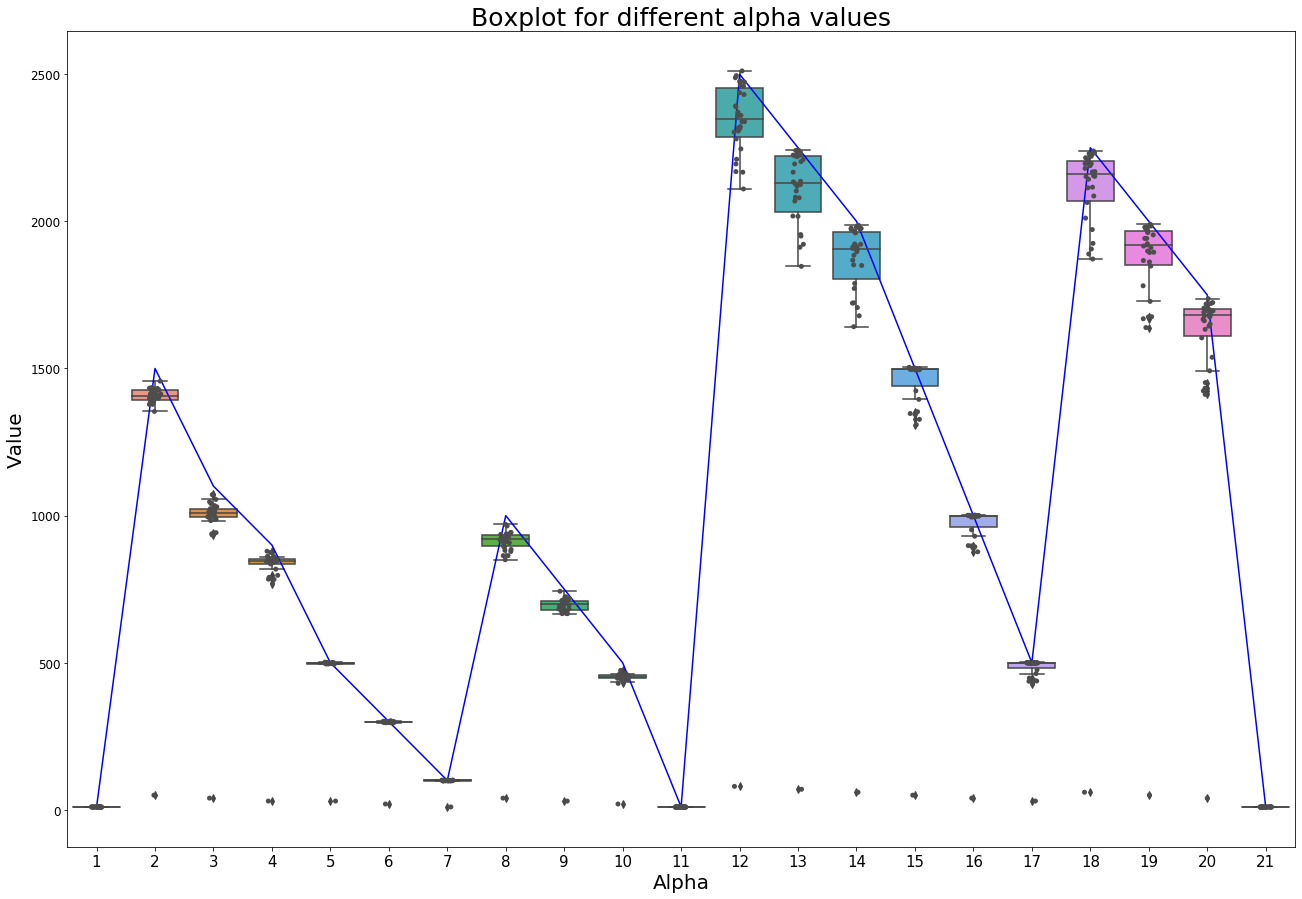

In [346]:
alpha_name_list = []
for i in range(1, 22):
    alpha_name_list.append(str(i))
    

final_alpha_df_beta_fixed = pd.DataFrame(final_alpha_list_beta_fixed, columns=alpha_name_list)


fig, ax = plt.subplots(figsize = (22,15))
sns.boxplot(data=final_alpha_df_beta_fixed)
sns.stripplot(data=final_alpha_df_beta_fixed, color = '.3', size = 5)

locs=ax.get_xticks()
ax.plot(locs, alpha_init, 'b-')

plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Value', fontsize = 20)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
plt.title('Boxplot for different alpha values', fontsize = 25) 
fig.savefig("Boxplot for different alpha values with beta fixed")

# boxplot for tran

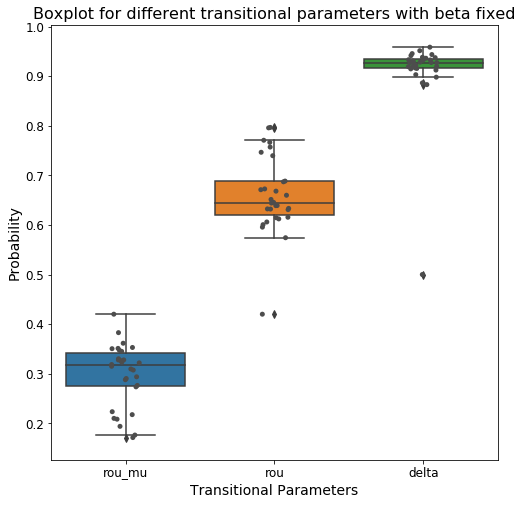

In [349]:
rou_mu_beta_fixed = []
rou_beta_fixed = []
delta_beta_fixed = []
for element in final_trans_beta_fixed:
    rou_mu_beta_fixed.append(element['AUG'][0])
    rou_beta_fixed.append(element['AUG'][1])
    delta_beta_fixed.append(element['AUG'][2])
    
final_trans_df_beta_fixed = pd.DataFrame({"rou_mu":rou_mu_beta_fixed, "rou":rou_beta_fixed,"delta": delta_beta_fixed}, 
                                         columns=['rou_mu', 'rou', 'delta'])

fig, ax = plt.subplots(figsize = (8, 8))
sns.boxplot(data=final_trans_df_beta_fixed)
sns.stripplot(data=final_trans_df_beta_fixed, color=".3", size=5)


plt.xlabel('Transitional Parameters', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.rc('xtick', labelsize = 12)
plt.rc('ytick', labelsize = 12)
plt.title('Boxplot for different transitional parameters with beta fixed', fontsize = 16) 
fig.savefig("Boxplot for different transitional parameters with beta fixed")



# unmatched num

In [282]:
beta_list_beta_fixed = np.repeat([beta_init],30, axis = 1).reshape(30,21)

In [283]:
before_beta_fixed = differ_state(RNA_data, observed_data, start_alpha_list_beta_fixed, beta_list_beta_fixed, E, start_trans_beta_fixed, stop_codon_list, state_list_true)
after_beta_fixed = differ_state(RNA_data, observed_data, final_alpha_list_beta_fixed, beta_list_beta_fixed, E, final_trans_beta_fixed, stop_codon_list, state_list_true)




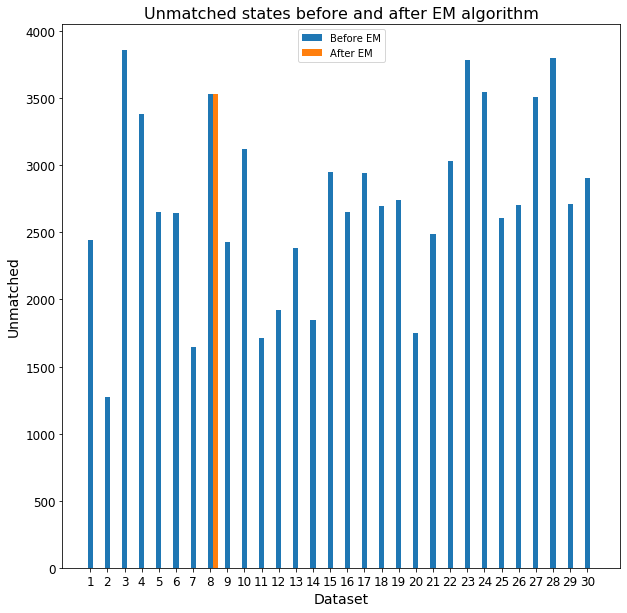

In [324]:
fig, ax = plt.subplots(figsize = (10,10))
plt.xticks(np.arange(1, 31, 1))
ind = np.arange(1, 31, 1)
width = 0.3
plt.bar(ind, before_beta_fixed, width, label = 'Before EM')
plt.bar(ind + width, after_beta_fixed, width, label = 'After EM') 
plt.xlabel('Dataset', fontsize = 14)
plt.ylabel('Unmatched', fontsize = 14)
plt.title('Unmatched states before and after EM algorithm', fontsize = 16) 
plt.legend(loc = 'best')
fig.savefig("Unmatched states before and after EM algorithm with beta fixed")

In [285]:
after_beta_fixed

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 3528,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0]